# Data Processing and Versioning

In [456]:
%matplotlib inline
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.pyplot import figure
import seaborn as sn
from pathlib import Path
from google.cloud import aiplatform, storage

In [457]:
# import dataset

df = pd.read_csv('Dataset/weather_dataset_raw.csv')

# 1. Data quality assessment 

In [458]:
df.head()

,S_No,Timestamp,Location,Temperature_C,Apparent_Temperature_C,Humidity,Wind_speed_kmph,Wind_bearing_degrees,Visibility_km,Pressure_millibars,Weather_conditions
0,0,2006-04-01 00:00:00+02:00,"Port of Turku, Finland",9.472222,7.388889,0.89,14.1197,251,15.8263,1015.13,rain
1,1,2006-04-01 01:00:00+02:00,"Port of Turku, Finland",9.355556,7.227778,0.86,14.2646,259,15.8263,1015.63,rain
2,2,2006-04-01 02:00:00+02:00,"Port of Turku, Finland",9.377778,9.377778,0.89,3.9284,204,14.9569,1015.94,rain
3,3,2006-04-01 03:00:00+02:00,"Port of Turku, Finland",8.288889,5.944444,0.83,14.1036,269,15.8263,1016.41,NaN
4,4,2006-04-01 04:00:00+02:00,"Port of Turku, Finland",8.755556,6.977778,0.83,11.0446,259,15.8263,1016.51,rain


In [459]:
df.describe()

,S_No,Temperature_C,Apparent_Temperature_C,Humidity,Wind_speed_kmph,Wind_bearing_degrees,Visibility_km,Pressure_millibars
count,96453.000000,96453.000000,96453.000000,96453.000000,96453.000000,96453.000000,96453.000000,96453.000000
mean,48226.000000,11.932678,10.855029,0.734899,10.810640,187.509232,10.347325,1003.235956
std,27843.727094,9.551546,10.696847,0.195473,6.913571,107.383428,4.192123,116.969906
min,0.000000,-21.822222,-27.716667,0.000000,0.000000,0.000000,0.000000,0.000000
25%,24113.000000,4.688889,2.311111,0.600000,5.828200,116.000000,8.339800,1011.900000
50%,48226.000000,12.000000,12.000000,0.780000,9.965900,180.000000,10.046400,1016.450000
75%,72339.000000,18.838889,18.838889,0.890000,14.135800,290.000000,14.812000,1021.090000
max,96452.000000,39.905556,39.344444,1.000000,63.852600,359.000000,16.100000,1046.380000


In [460]:
df.shape

(96453, 11)

In [461]:
df.dtypes

S_No                        int64
Timestamp                  object
Location                   object
Temperature_C             float64
Apparent_Temperature_C    float64
Humidity                  float64
Wind_speed_kmph           float64
Wind_bearing_degrees        int64
Visibility_km             float64
Pressure_millibars        float64
Weather_conditions         object
dtype: object

#### Check for missing data

In [462]:
df.isnull().values.any()

np.True_

# 2. Calibrate missing data

In [463]:
#df['Weather_conditions'].fillna(method='ffill',inplace=True,axis=0)
df['Weather_conditions'] = df['Weather_conditions'].ffill()

In [464]:
df.isnull().values.any()

np.False_

In [465]:
df.Weather_conditions.value_counts()

Weather_conditions
rain     82271
snow     10712
clear     3470
Name: count, dtype: int64

In [466]:
#df["Weather_conditions"].replace({"snow": "no_rain", "clear": "no_rain"}, inplace=True)
df["Weather_conditions"] = df["Weather_conditions"].replace({"snow": "no_rain", "clear": "no_rain"})

In [467]:
df.Weather_conditions.value_counts()

Weather_conditions
rain       82271
no_rain    14182
Name: count, dtype: int64

#### Convert Timestamp to Datetime format

In [468]:
df['Timestamp'] = pd.to_datetime(df['Timestamp'], utc=True)

#### Convert text data to numeric using Label Encoding

In [469]:
y = df['Weather_conditions']

In [470]:
from sklearn.preprocessing import LabelEncoder
le=LabelEncoder()
y=le.fit_transform(y)

In [471]:
y = pd.DataFrame(data=y, columns=["Current_weather_condition"])

In [472]:
df = pd.concat([df, y], axis=1)

In [473]:
df.Current_weather_condition.value_counts()

Current_weather_condition
1    82271
0    14182
Name: count, dtype: int64

In [474]:
df.drop(['Weather_conditions'],axis=1,inplace=True)

In [475]:
df.head()

,S_No,Timestamp,Location,Temperature_C,Apparent_Temperature_C,Humidity,Wind_speed_kmph,Wind_bearing_degrees,Visibility_km,Pressure_millibars,Current_weather_condition
0,0,2006-03-31 22:00:00+00:00,"Port of Turku, Finland",9.472222,7.388889,0.89,14.1197,251,15.8263,1015.13,1
1,1,2006-03-31 23:00:00+00:00,"Port of Turku, Finland",9.355556,7.227778,0.86,14.2646,259,15.8263,1015.63,1
2,2,2006-04-01 00:00:00+00:00,"Port of Turku, Finland",9.377778,9.377778,0.89,3.9284,204,14.9569,1015.94,1
3,3,2006-04-01 01:00:00+00:00,"Port of Turku, Finland",8.288889,5.944444,0.83,14.1036,269,15.8263,1016.41,1
4,4,2006-04-01 02:00:00+00:00,"Port of Turku, Finland",8.755556,6.977778,0.83,11.0446,259,15.8263,1016.51,1


#### Future Weather_condition

In [476]:
df['Future_weather_condition'] = df.Current_weather_condition.shift(4, axis = 0) 

In [477]:
df.dropna(inplace=True)

In [478]:
df['Future_weather_condition'] = df['Future_weather_condition'].apply(np.int64)

In [479]:
# Result - rain is 0 and no_rain is 1
df.head()

,S_No,Timestamp,Location,Temperature_C,Apparent_Temperature_C,Humidity,Wind_speed_kmph,Wind_bearing_degrees,Visibility_km,Pressure_millibars,Current_weather_condition,Future_weather_condition
4,4,2006-04-01 02:00:00+00:00,"Port of Turku, Finland",8.755556,6.977778,0.83,11.0446,259,15.8263,1016.51,1,1
5,5,2006-04-01 03:00:00+00:00,"Port of Turku, Finland",9.222222,7.111111,0.85,13.9587,258,14.9569,1016.66,1,1
6,6,2006-04-01 04:00:00+00:00,"Port of Turku, Finland",7.733333,5.522222,0.95,12.3648,259,9.9820,1016.72,1,1
7,7,2006-04-01 05:00:00+00:00,"Port of Turku, Finland",8.772222,6.527778,0.89,14.1519,260,9.9820,1016.84,1,1
8,8,2006-04-01 06:00:00+00:00,"Port of Turku, Finland",10.822222,10.822222,0.82,11.3183,259,9.9820,1017.37,1,1


## b) Understanding Correlations between data (columns)

In [480]:
df.drop(columns=['Location'],axis=1,inplace=True) 
df.corr(method="pearson")

,S_No,Timestamp,Temperature_C,Apparent_Temperature_C,Humidity,Wind_speed_kmph,Wind_bearing_degrees,Visibility_km,Pressure_millibars,Current_weather_condition,Future_weather_condition
S_No,1.000000,0.993978,0.025460,0.026591,0.041773,-0.006393,-0.027760,0.109075,0.016650,0.083009,0.082774
Timestamp,0.993978,1.000000,0.030604,0.031177,0.044408,-0.013212,-0.027330,0.100123,0.014198,0.076071,0.075879
Temperature_C,0.025460,0.030604,1.000000,0.992629,-0.632254,0.008959,0.029995,0.392876,-0.005446,0.378350,0.348167
Apparent_Temperature_C,0.026591,0.031177,0.992629,1.000000,-0.602570,-0.056646,0.029039,0.381749,-0.000218,0.383877,0.357662
Humidity,0.041773,0.044408,-0.632254,-0.602570,1.000000,-0.224957,0.000720,-0.369223,0.005451,-0.130966,-0.096626
Wind_speed_kmph,-0.006393,-0.013212,0.008959,-0.056646,-0.224957,1.000000,0.103815,0.100745,-0.049264,0.094135,0.066179
Wind_bearing_degrees,-0.027760,-0.027330,0.029995,0.029039,0.000720,0.103815,1.000000,0.047567,-0.011653,0.059540,0.061013
Visibility_km,0.109075,0.100123,0.392876,0.381749,-0.369223,0.100745,0.047567,1.000000,0.059815,0.233356,0.227457
Pressure_millibars,0.016650,0.014198,-0.005446,-0.000218,0.005451,-0.049264,-0.011653,0.059815,1.000000,0.040329,0.038392
Current_weather_condition,0.083009,0.076071,0.378350,0.383877,-0.130966,0.094135,0.059540,0.233356,0.040329,1.000000,0.808768


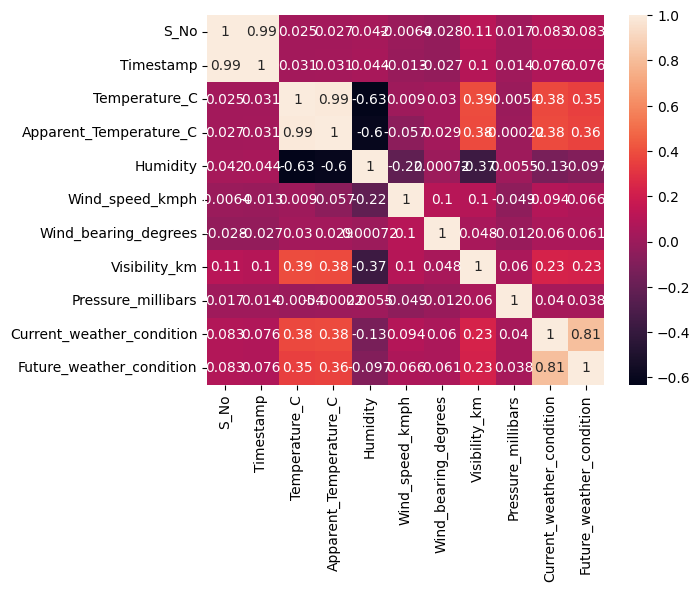

In [481]:
corrMatrix = df.corr()
sn.heatmap(corrMatrix, annot=True)
plt.show()

In [482]:
# Filter or drop irrelevent data columns
df.drop(['S_No', 'Apparent_Temperature_C'],axis=1,inplace=True)

<Axes: >

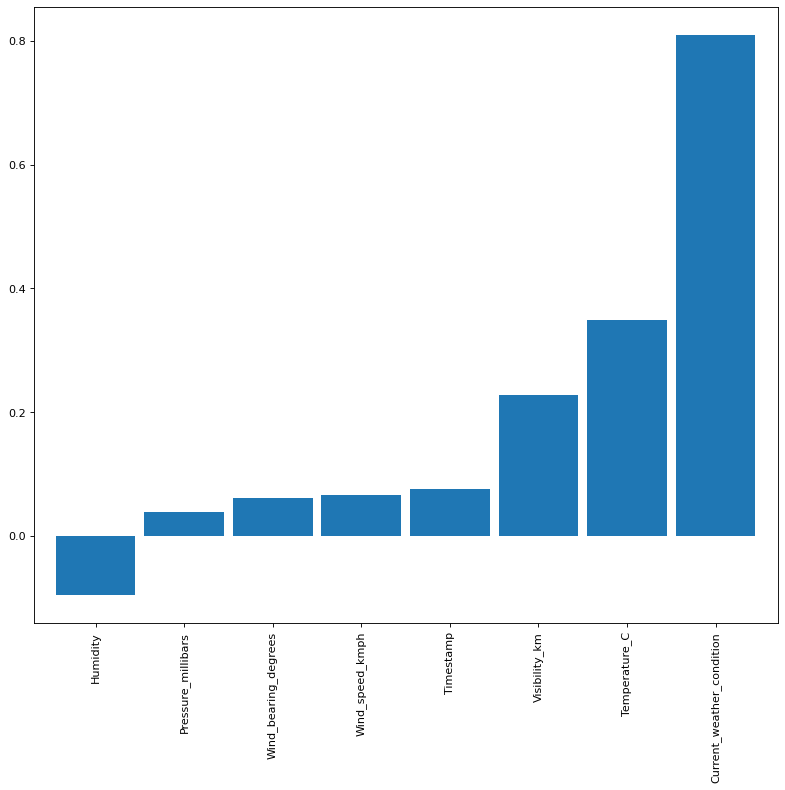

In [483]:
from matplotlib.pyplot import figure
figure(num=None, figsize=(12, 10), dpi=80, facecolor='w', edgecolor='w')
df.corr(method ='pearson')['Future_weather_condition'].sort_values(ascending=True).drop(['Future_weather_condition']).plot(kind='bar', width=0.9)

## d) Timeseries analysis of Temperature

In [484]:
time = df['Timestamp']
temp = df['Temperature_C']

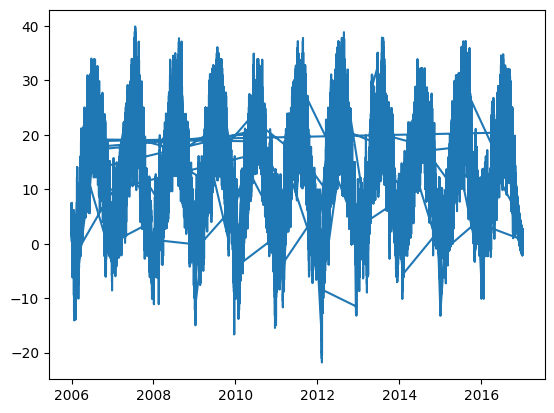

In [485]:
## plot graph
plt.plot(time, temp)
plt.show()

In [486]:
# Save processed dataset 
df.to_csv('Dataset/weather_dataset_processed.csv',index=False)

## Register dataset to the GCP vertex AI

In [487]:
# project="totemic-splicer-454710-h1",
# location="us-east1"

In [488]:
aiplatform.init(project="totemic-splicer-454710-h1", location="us-east1")

In [489]:
# get the datastore to upload prepared data
# datastore = workspace.get_default_datastore()
storage_client = storage.Client()

In [490]:
# upload the local file from src_dir to the target_path in datastore
# datastore.upload(src_dir='Dataset', target_path='data')
def upload_to_gcs(local_path, gcs_path):
    bucket_name = "mlops_learning_gdj32"  # Your default bucket
    bucket = storage_client.bucket(bucket_name)
    
    for local_file in Path(local_path).rglob("*"):
        if local_file.is_file():
            blob_path = f"{gcs_path}/{local_file.relative_to(local_path)}"
            blob = bucket.blob(blob_path)
            blob.upload_from_filename(str(local_file))
            print(f"Uploaded {local_file} to gs://{bucket_name}/{blob_path}")
upload_to_gcs(local_path='Dataset', gcs_path='data')

Uploaded Dataset/weather_dataset_raw.csv to gs://mlops_learning_gdj32/data/weather_dataset_raw.csv
Uploaded Dataset/weather_dataset_processed.csv to gs://mlops_learning_gdj32/data/weather_dataset_processed.csv


In [491]:
# dataset = Dataset.Tabular.from_delimited_files(datastore.path('data/weather_dataset_processed.csv'))
dataset = aiplatform.TabularDataset.create(
    display_name="mlops_learning",
    gcs_source="gs://mlops_learning_gdj32/data/weather_dataset_processed.csv",
)

Creating TabularDataset
Create TabularDataset backing LRO: projects/28645706877/locations/us-east1/datasets/3901955660744491008/operations/4847069880018534400
TabularDataset created. Resource name: projects/28645706877/locations/us-east1/datasets/3901955660744491008
To use this TabularDataset in another session:
ds = aiplatform.TabularDataset('projects/28645706877/locations/us-east1/datasets/3901955660744491008')


In [ ]:
# Register Dataset to workspace

In [38]:
# weather_ds = dataset.register(workspace=workspace,
#                                  name='processed_weather_data_portofTurku',
#                                  description='processed weather data')